## Bible-1_06_Ensemble
Please visit below links, Ensemble theories and Implementation are explained.

## English


*   Theory : https://wikidocs.net/165452 and https://wikidocs.net/165453 and https://wikidocs.net/165454 and https://wikidocs.net/165454
*   Implementation : https://wikidocs.net/165473 and https://wikidocs.net/165474  and https://wikidocs.net/165475


## 한글



*   이론 : https://wikidocs.net/164322 and https://wikidocs.net/164645 and https://wikidocs.net/164307 and https://wikidocs.net/164356
*   구현 : https://wikidocs.net/165167 and https://wikidocs.net/164740 and https://wikidocs.net/165000



You can understand it by comparing it with "06_00_graph_mode_CNN_sequential_subclassing_baseline.py"

Below is the same as baseline code.

11501568/11490434 [==============================] - 0s 0us/step
[5 0 4 1 9 2 1 3 1 4]
(60000, 28, 28)


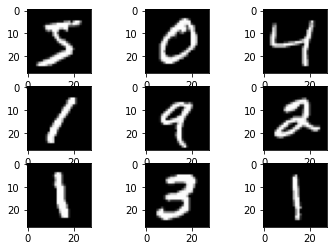

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras import Model, Sequential

from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

# Hyper-parameters 
input_size = 784 # 28x28
hidden_size = 256 
num_classes = 10
EPOCHS = 5
batch_size = 100
learning_rate = 0.001

# print(tf.__version__)
## MNIST Dataset #########################################################
mnist = tf.keras.datasets.mnist
# class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
##########################################################################

## Fashion MNIST Dataset #################################################
# mnist = tf.keras.datasets.fashion_mnist
# class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
##########################################################################
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()    

# Change data type as float. If it is unt type, it might cause error 
X_train, X_test = X_train / 255.0, X_test / 255.0

print(Y_train[0:10])
print(X_train.shape)

# in the case of Keras or TF2, type shall be [image_size, image_size, 1]
# if it is RGB type, type shall be [image_size, image_size, 3]
# For MNIST or Fashion MNIST, it need to reshape
X_train_new_axis = np.expand_dims(X_train, axis=-1)
X_test_new_axis = np.expand_dims(X_test, axis=-1)
    
Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)    
    
# 입력된 buffer_size만큼 data를 채우고 무작위로 sampling하여 새로운 data로 바꿉니다.
# 완벽한 셔플링을 위해서는 데이터 세트의 전체 크기보다 크거나 같은 버퍼 크기가 필요합니다.
# 만약 작은 데이터수보다 작은 buffer_size를 사용할경우,
# 처음에 설정된 buffer_size만큼의 data안에서 임의의 셔플링이 발생합니다.
shuffle_size = 100000

train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train_new_axis, Y_train)).shuffle(shuffle_size).batch(batch_size)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test_new_axis, Y_test)).batch(batch_size)

# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    # if you want to invert color, you can use 'gray_r'. this can be used only for MNIST, Fashion MNIST not cifar10
    # pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray_r'))
    
# show the figure
plt.show()


"""
def create_model():
    model = Sequential()
    
    model.add(Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu, padding='SAME', 
                                  input_shape=(28, 28, 1)))
    model.add(MaxPool2D(padding='SAME'))
        
    model.add(Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
    model.add(MaxPool2D(padding='SAME'))
    
    model.add(Flatten())
    model.add(Dense(128, activation=tf.nn.relu))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation=tf.nn.softmax))
    
    return model

model = create_model()
"""
model = Sequential([
    Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu, padding='SAME',input_shape=(28, 28, 1)),
    MaxPool2D(padding='SAME'),
    Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu, padding='SAME'),
    MaxPool2D(padding='SAME'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')
])

The first thing to change is to define the model as a List.

In [2]:
models = []
num_models = 3
for m in range(num_models):
    models.append(model)

For bagging models you should not use "@tf.function" . I tried to find a part about it, but I couldn't find a posting that explains it. However, in the case of bagging, we will move on to the next step only knowing that it will not work. If any of you readers know the exact reason for this, I would appreciate it if you could send me an email.

```
# @tf.function
```

Below is the same as baseline code.

In [3]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
        y_pred=logits, y_true=labels, from_logits=True))    
    return loss   

def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

Accuracy defines three models as follows. Please compare with baseline code.

In [4]:
def evaluate(models, images, labels):
    predictions = np.zeros_like(labels)
    for model in models:
        logits = model(images, training=False)
        predictions += logits
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

Also checkpoints need to be modified like below. 

In [5]:
checkpoints = []
for m in range(num_models):
    checkpoints.append(tf.train.Checkpoint(cnn=models[m]))

Below is the same as baseline code.

In [6]:
def train_step(model, images, labels):
    gradients = grad(model, images, labels)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

from tqdm import tqdm, tqdm_notebook, trange

Training part and test part need tibe modified. Please compare with baseline code.

In [7]:
for epoch in range(EPOCHS):

    with tqdm_notebook(total=len(train_ds), desc=f"Train Epoch {epoch+1}") as pbar:    
        train_losses = []
        train_accuracies = []
        
        for images, labels in train_ds:
            for model in models:
                train_step(model, images, labels)
            
                loss_val = loss_fn(model, images, labels)
                train_losses.append(loss_val / num_models)
            
            acc = 100 * evaluate(models, images, labels)

            train_accuracies.append(acc)
            
            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.4f} ({np.mean(train_losses):.4f}) Acc: {acc:.3f} ({np.mean(train_accuracies):.3f})")

    with tqdm_notebook(total=len(test_ds), desc=f"Test_ Epoch {epoch+1}") as pbar:    
        test_losses = []
        test_accuracies = []
        for test_images, test_labels in test_ds:
            for model in models:
                loss_val = loss_fn(model, test_images, test_labels)

                test_losses.append(loss_val)
            acc = 100 * evaluate(models, test_images, test_labels)
            
            test_accuracies.append(acc)

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.4f} ({np.mean(test_losses):.4f}) Acc: {acc:.3f} ({np.mean(test_accuracies):.3f})")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


Train Epoch 1:   0%|          | 0/600 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Test_ Epoch 1:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 2:   0%|          | 0/600 [00:00<?, ?it/s]

Test_ Epoch 2:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 3:   0%|          | 0/600 [00:00<?, ?it/s]

Test_ Epoch 3:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 4:   0%|          | 0/600 [00:00<?, ?it/s]

Test_ Epoch 4:   0%|          | 0/100 [00:00<?, ?it/s]

Train Epoch 5:   0%|          | 0/600 [00:00<?, ?it/s]

Test_ Epoch 5:   0%|          | 0/100 [00:00<?, ?it/s]